In [1]:
!pip install pennylane

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 65.5 MB/s eta 0:00:00


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

### Task 2 - Variational Classifier
Summary of the learning from the PennyLane tutorial.

#### 1. Quantum Circuit and Nodes
In this notebook, we change the example 4 qubits into 5 qubits. First, we create the layer function with the a ring of CNOT gates.

Next, we prepare the states based on the input bitstring expression.

Finally, we construct the entire circuit and added a bias term.

In [8]:
dev = qml.device("default.qubit")
def layer(layer_weights):
    for wire in range(5):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 4], [4, 0]):
        qml.CNOT(wires)

In [9]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3, 4])

In [10]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

In [11]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

#### 2.Cost
We use square loss to do optimization in this case, and we also create an accuracy function to monitor.

Finally, we define the cost function to wrap the loss function.

In [12]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

#### 3. Optimization

Since we are changing from 4 qubits to 5 qubits, we need to modify the training and testing data, below the function is to create the train and test data of parity function.

And the following cell is to read the train data, and convert the label from {0,1} into {-1,1}.

In [7]:
import random
# prepare train and test data
data = []
for i in range(32):
    bs = np.binary_repr(i)
    bs = '0' *(5-len(bs))+bs
    if bs.count('1') % 2==0:
        label = '0'
    else:
        label = '1'
    bs = bs + label
    bs = ' '.join(bs)
    data.append(bs)

random.shuffle(data)
train_data = data[:23]
test_data = data[23:]

with open('parity_train.txt', 'w') as f:
    for line in train_data:
        f.write(f"{line}\n")

with open('parity_test.txt', 'w') as f:
    for line in test_data:
        f.write(f"{line}\n")

In [13]:
data = np.loadtxt("parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1 1], y = -1
x = [0 1 0 1 1], y = 1
x = [0 0 0 1 0], y = 1
x = [1 1 1 1 1], y = 1
x = [0 0 1 1 1], y = 1
x = [1 0 1 1 0], y = 1
x = [1 1 1 0 0], y = 1
x = [1 1 0 0 1], y = 1
x = [1 0 0 0 1], y = -1
x = [0 1 1 1 0], y = 1
x = [1 1 0 1 0], y = 1
x = [0 0 0 0 0], y = -1
x = [1 1 1 0 1], y = -1
x = [1 0 0 1 0], y = -1
x = [0 1 1 0 1], y = 1
x = [1 0 1 0 0], y = -1
x = [0 1 0 0 1], y = -1
x = [0 1 0 1 0], y = -1
x = [1 0 0 0 0], y = 1
x = [1 1 1 1 0], y = -1
x = [1 0 1 1 1], y = -1
x = [1 1 0 0 0], y = -1
x = [0 1 0 0 0], y = 1


We initialize the weights and bias for the optimization randomly, with the specified number of qubits and number of layers.
The dimension of the weights parameter will be $(#layers, #qubits, 3)$. And bias is just a scalar initialized as 0.

In [14]:
np.random.seed(0)
num_qubits = 5
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]
  [ 0.00761038  0.00121675  0.00443863]]

 [[ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]
  [ 0.02269755 -0.01454366  0.00045759]
  [-0.00187184  0.01532779  0.01469359]]]
Bias:  0.0


Next we initialize the optimizer with stepsize = 0.5 and momentum = 0.9 (default value).

In [15]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

We train it with 100 steps, we can see that the cost and accuracy fluctuated at the beginning and converge to perfect accuracy at around step 50.

In [16]:
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 2.6900158 | Accuracy: 0.5217391
Iter:    2 | Cost: 4.7349735 | Accuracy: 0.5217391
Iter:    3 | Cost: 1.8421047 | Accuracy: 0.5217391
Iter:    4 | Cost: 2.6642193 | Accuracy: 0.5217391
Iter:    5 | Cost: 1.6784966 | Accuracy: 0.5217391
Iter:    6 | Cost: 1.6670397 | Accuracy: 0.4782609
Iter:    7 | Cost: 1.0704076 | Accuracy: 0.4347826
Iter:    8 | Cost: 2.0777505 | Accuracy: 0.4782609
Iter:    9 | Cost: 1.1425854 | Accuracy: 0.5217391
Iter:   10 | Cost: 1.7054129 | Accuracy: 0.4347826
Iter:   11 | Cost: 1.6233397 | Accuracy: 0.5217391
Iter:   12 | Cost: 0.9664583 | Accuracy: 0.6086957
Iter:   13 | Cost: 0.7621440 | Accuracy: 0.7391304
Iter:   14 | Cost: 1.3398610 | Accuracy: 0.5217391
Iter:   15 | Cost: 0.7853202 | Accuracy: 0.8260870
Iter:   16 | Cost: 1.7693099 | Accuracy: 0.5217391
Iter:   17 | Cost: 1.5207458 | Accuracy: 0.4782609
Iter:   18 | Cost: 1.1015180 | Accuracy: 0.5217391
Iter:   19 | Cost: 1.1696999 | Accuracy: 0.5652174
Iter:   20 | Cost: 1.0848728 | 

Finally we test it on the test data, which is never seen by the circuit. The accuracy is 1.

In [17]:
data = np.loadtxt("parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 1 0 1], y = -1, pred=-1.0
x = [0 1 1 1 1], y = -1, pred=-1.0
x = [0 0 1 1 0], y = -1, pred=-1.0
x = [1 1 0 1 1], y = -1, pred=-1.0
x = [0 0 1 0 0], y = 1, pred=1.0
x = [1 0 1 0 1], y = 1, pred=1.0
x = [1 0 0 1 1], y = 1, pred=1.0
x = [0 0 0 0 1], y = 1, pred=1.0
x = [0 1 1 0 0], y = -1, pred=-1.0
Accuracy on unseen data: 1.0


#### 4. Iris Classification
Here, we move on to a real-valued data.

In [18]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

test our ```get_angles``` function

In [19]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)

@qml.qnode(dev)
def test(angles):
    state_preparation(angles)
    return qml.state()

state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.795036  0.278265 -0.      ]


Similarly, we define a layer function for 2-qubit situation. And a similar cost function that calls the variational classifier function, and hence the circuit function.

In [20]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])

def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

#### 5. Iris Data
We conduct exploratory analysis on the Iris data with 2 classes.

For data preparation, we first normalize the data, calculate the angles that we need to convert the classical data into quantum information.

In [21]:
data = np.loadtxt("iris_classes1and2_scaled.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


We plot the data, we can see that the normalized data looks very different from the original data.

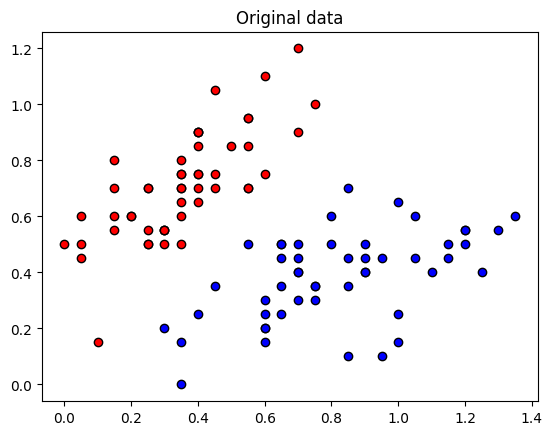

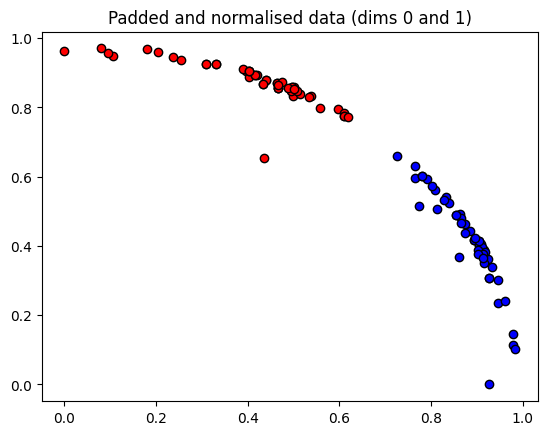

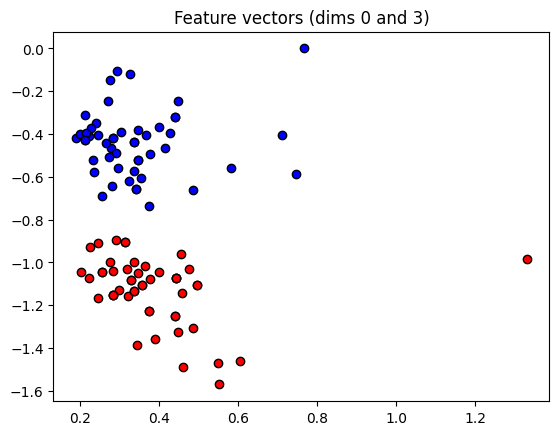

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

Next we split the train (75%) and test (25%) data.

In [23]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

#### 6. Iris Classification Optimization
In this section, we changed the original 6 layers to 7 layers. And similarly, we initialize the weights and bias randomly.

In [27]:
num_qubits = 2
num_layers = 7

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

This time we use the optimizer with step size = 0.01. And we train with 60 steps. We can see that the train and valid accuracy increased to 100% after training.

In [28]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )


Iter:     2 | Cost: 1.7248036 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.3740809 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     6 | Cost: 1.1113450 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     8 | Cost: 0.9683437 | Acc train: 0.5866667 | Acc validation: 0.6000000
Iter:    10 | Cost: 1.0534330 | Acc train: 0.5200000 | Acc validation: 0.4400000
Iter:    12 | Cost: 0.9574287 | Acc train: 0.5466667 | Acc validation: 0.4800000
Iter:    14 | Cost: 0.8694121 | Acc train: 0.7066667 | Acc validation: 0.6800000
Iter:    16 | Cost: 0.8275965 | Acc train: 0.8400000 | Acc validation: 0.8400000
Iter:    18 | Cost: 0.7912875 | Acc train: 0.8800000 | Acc validation: 1.0000000
Iter:    20 | Cost: 0.7196594 | Acc train: 0.8266667 | Acc validation: 0.8000000
Iter:    22 | Cost: 0.6660867 | Acc train: 0.7333333 | Acc validation: 0.7200000
Iter:    24 | Cost: 0.5771561 | Acc train: 0.8266667 | Acc validation: 0.8000000
Iter:    26 | Cost: 0.463821

Finally we plot the decision boundary. We can see that it successfully predict where to split the two classes.

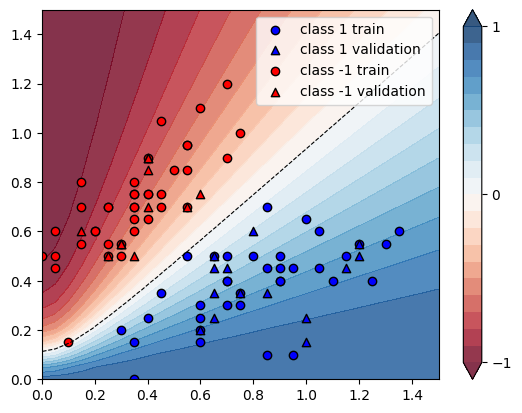

In [29]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")

plt.legend()
plt.show()